In [1]:
#Part 1 PDF for Hubble constant

using CSV,DataFrames,Plots,Statistics,LinearAlgebra
frbs = CSV.read("frb.csv",header = 1, delim = ",",ignorerepeated=true,DataFrame)

Row,redshift,DM_obs,DM_MW,name
,Float64,Float64,Float64,String15
1,0.0337,348.8,199.0,FRB180916
2,0.1178,338.7,37.2,FRB190608
3,0.19273,558.0,188.0,FRB121102
4,0.291,363.6,57.3,FRB190102
5,0.3214,361.42,40.5,FRB180924
6,0.378,321.4,57.8,FRB190611
7,0.4755,589.27,102.0,FRB181112
8,0.522,593.1,56.4,FRB190711
9,0.66,760.8,37.0,FRB190523


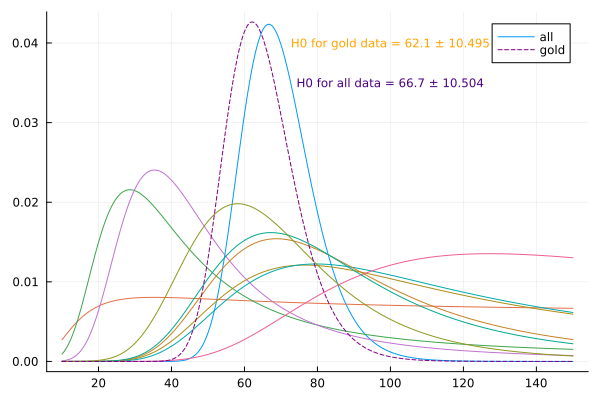

In [9]:
#constants
Ωb=0.02237
χ=0.88
G=6.67408e-11
mₚ=1.6726219e-27
Ωm= 0.143
c=299792458
f=0.84
#here we are taking H=100H0

#DM theory = DMLSS+DM_milkyway
function DM(z,h,H0)
    x=collect(0:h:z)
    one=ones(length(x))
    E=sqrt.(Ωm*((one + x).^3) + (one*((H0/100)^2-Ωm)))
    int=sum(((χ*f*3*100*c*Ωb)/(8*pi*mₚ*G))*((one + x)./E)*h*(1.05026504028913e-42))
    return int+ 100/(1+z)
end

#Sigma without milkyway
    
function sigma(z)
    return sqrt((50 / (1 + z))^2 + (40 + 140 * z)^2)
end

#Sigma with milkyway
    
function sigma_mw(z)
    return sqrt((50 / (1 + z))^2 + (40 + 140 * z)^2 +30^2)
end

#all data 
DMo = frbs.DM_obs - frbs.DM_MW
z = frbs.redshift
dh= 0.1
H = collect(10:dh:150)
h=0.001

#probability distribution function for  different H values
function PDF(z,h,DMo,H,Ωb,Ωm)
    
    n = length(z)
    sigma1 = sigma.(z)
    L= zeros(n)
    pdf= zeros(length(H))
    for i in 1:length(H)  
        for j in 1:n
            L[j]=(1/sqrt(2*pi*sigma1[j]^2))*(exp((-(DMo[j]-DM(z[j],h,H[i]))^2)/(2*sigma1[j]^2)))
        end
        pdf[i]= prod(L[j] for j in 1:n)
    end
    return pdf
end


#other than gold data
z2=[0.0337, 0.1178, 0.378]
DMn=[149.8,301.5,263.6]




#normalization of PDF for all data
v=PDF(z,h,DMo,H,Ωb,Ωm)
v=v/sum(v*dh)

#ploting for all data
plot(H,v,label="all")

#Plotting for individual data


for i in 1:length(z)
    o=PDF(z[i],h,DMo[i],H,Ωb,Ωm)
    o=o/sum(o*dh)
    plot!(H,o,label="")
end
#ploting for gold data
DMg = [370.0,320.92,263.6,579.27,536.7,723.8]
z1 = [0.19273,0.291,0.3214,0.4755,0.522,0.66]
q=PDF(z1,h,DMg,H,Ωb,Ωm)
q=q/sum(q*dh)
plot!(H,q,label="gold",linestyle=:dash,color=:purple)

H_max_all=H[argmax(v)]
H_max_gold=H[argmax(q)]

#sigma in H values
function H_sigma(H,pdf)
    H0=H[argmax(pdf)]
    one = ones(length(H))
    sigma=sum(diag(((H-(one*H0)).^2)*transpose(pdf))/(sum(pdf)))
    return sqrt(sigma)
end


H_sigma_gold=H_sigma(H,q)
H_sigma_all=H_sigma(H,v)

annotate!(100, 0.04, text("H0 for gold data = $H_max_gold ± $(round(H_sigma_gold, digits=3))", 8, :orange))
annotate!(100, 0.035, text("H0 for all data = $H_max_all ± $(round(H_sigma_all, digits=3))", 8, :indigo))




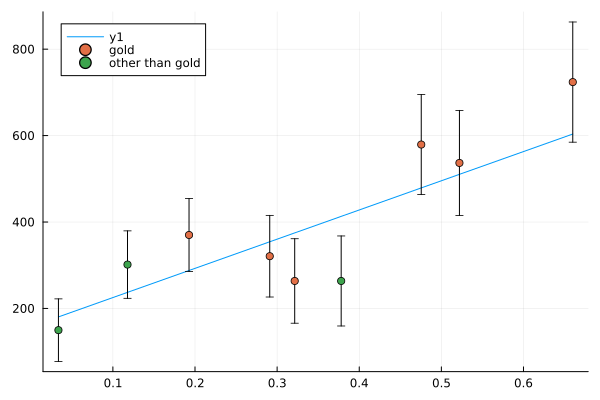

In [11]:
function linear_fit(x,y,σy)
    a=ones(length(x))
    A=hcat(a,x)
    C=diagm(σy.^2)
    Q=inv(transpose(A)*inv(C)*A)
    P=transpose(A)*inv(C)*y
    W=Q*P
    Y=x*W[2]+a*W[1]
    plot(x,Y)
end
sigma_mw1=sigma_mw.(z)
sigma2=sigma_mw.(z1)
sigma3=sigma_mw.(z2)

linear_fit(z,DMo,sigma_mw1)
scatter!(z1,DMg,yerr=sigma2,label="gold")
scatter!(z2,DMn,yerr=sigma3, label="other than gold")